## First look at SNPs for scallop parentage panel
**20170411NL**

I need to help my collaborator find SNPs for a parentage panel. Ideally, they'd be SNPs with fairly high minor allele frequencies. And, they'd need to be flanked by regions that don't vary so we can build primers. I should also filter those out with high Fis values, as the distribution of Fis values departed from 0 more than I'd like.

Steps:
1. Find RAD tags with SNPs that aren't in first or last 30 bp.
2. Find MAF of SNPs in these RAD tags.
3. Order them by decreasing MAF
4. Get rank Fis, determine cut off, and filter out for Fis threshold

In [2]:
import matplotlib.pyplot as plt
import numpy as np

In [3]:
cd /mnt/hgfs/SHARED_FOLDER/WorkingFolder

/mnt/hgfs/SHARED_FOLDER/WorkingFolder


In [4]:
# read in Genepop file to get header of SNP names
myfile = open("Stacks_2/filtered_genepop_files/postMAF_postMV_asGP_20170322.gen", "r")

first_lines = []
for i in range(0,2):
    line = myfile.readline()
    first_lines.append(line)
myfile.close()

In [5]:
# extract line with SNP names
SNP_line = first_lines[1]
SNP_names = SNP_line.split(",")
print SNP_names[0:19]

['5_137', '13_72', '20_52', '20_59', '27_30', '27_62', '27_115', '31_69', '57_22', '57_74', '57_83', '62_90', '62_93', '62_98', '62_113', '63_87', '63_107', '75_59', '75_126']


In [6]:
# initiate dictionary to store RAD tag numbers as keys, 
# and positions as values in a list
RADtag_dict = {}

# initiate list of SNP names
RADtag_num_list = []

# loop through SNP names, parse SNP names and positions, fill dictionary
for SNP in SNP_names:# TESTING - MAKE SURE TO CHANGE BACK TO "for SNP in SNP_names:"
    name_list = SNP.split("_")
    SNP_num = int(name_list[0])
    position = int(name_list[1])
    if SNP_num not in RADtag_dict:
        RADtag_dict[SNP_num] = [position]
        RADtag_num_list.append(SNP_num)
    else:
        position_list = RADtag_dict[SNP_num]
        position_list.append(position)
        RADtag_dict[SNP_num] = position_list

In [7]:
# check that it worked
# from above, should correspond to: '5_137', '13_72', '20_52', '20_59'

print "SNP positions for RAD tags 5, 13, & 20"
print RADtag_dict[5]
print RADtag_dict[13]
print RADtag_dict[20]

print "\nFirst few RADtag numbers"
print RADtag_num_list[0:5]

SNP positions for RAD tags 5, 13, & 20
[137]
[72]
[52, 59]

First few RADtag numbers
[5, 13, 20, 27, 31]


In [8]:
# keep SNPs where no SNPs in RAD tag in first or last 30 bp

# initiate cut off
cutoff = 30

# initiate keep and lose SNP lists
keep_RADtags_30 = []
lose_RADtags = []

for RADtag in RADtag_num_list:
    positions = RADtag_dict[RADtag]
    if all(x > cutoff for x in positions) and all(x < (139-cutoff) for x in positions):
        keep_RADtags_30.append(RADtag)
    else:
        lose_RADtags.append(RADtag)
        
num_kept = len(keep_RADtags_30)
num_lost = len(lose_RADtags)
total = len(keep_RADtags_30) + len(lose_RADtags)
total2 = len(RADtag_num_list)

if total == total2:
    print "Filtering for RAD tags without SNPs in first or last " + str(cutoff) + " base pairs"
    print "Total: " + str(total) + " RADtags"
    print "\nKept: " + str(float(num_kept)/float(total)*100) + "%" " or " + str(num_kept) + " RADtags"
    print "Lost: " + str(float(num_lost)/float(total)*100) + "%"
else:
    "Error! You reappended to a list and now it's bologne."

Filtering for RAD tags without SNPs in first or last 30 base pairs
Total: 5556 RADtags

Kept: 32.1274298056% or 1785 RADtags
Lost: 67.8725701944%


### Here is the first 100 of 1785 RAD tag names that have SNPs that are not in the first or last 30 base pairs of the sequence:

In [9]:
print keep_RADtags_30[0:99]

[13, 20, 31, 63, 80, 86, 89, 94, 96, 128, 206, 219, 245, 248, 278, 304, 305, 308, 309, 337, 350, 370, 387, 398, 447, 455, 460, 461, 465, 485, 514, 571, 572, 615, 617, 628, 651, 672, 717, 735, 779, 790, 802, 806, 817, 819, 828, 839, 851, 859, 860, 883, 889, 891, 899, 903, 914, 922, 934, 943, 962, 974, 993, 995, 1038, 1051, 1055, 1058, 1078, 1093, 1140, 1161, 1169, 1172, 1201, 1206, 1210, 1219, 1234, 1255, 1263, 1271, 1274, 1276, 1277, 1330, 1333, 1352, 1419, 1437, 1438, 1440, 1447, 1459, 1463, 1492, 1498, 1511, 1528]


## Chat with peer

**20170413**
<br>I chatted with a peer who has built multiple parentage panels for amplicon sequencing, and got some good preliminary advice. Here are somethings I learned:

* They start with a 30 bp cut off for 100 bp reads, so I think it's safe for me to start with the same. 
* If analyzing data at the SNP level, you want a minor allele frequency close to .5. If analyzing data at the haplotype level, many haplotypes can be more informative even though the minor allele frequency can be a bit lower than .5. 
* If I want to find out whether rare haplotype is actually just sequencing error/paralog, I can look at the ratio of reads. I'd expect a paralog to be evenly dispersed, like each of 4 alleles having 25% of the reads, or one having 50% and two having 25%. If sequencing error, should be really rare. Could also be worth filtering and saying keep only if haplotype appears in at least X number of individuals, or at least certain depth in an individual. Essentially, recalling genotypes in Marine's script.
* Their amplicon size ranges from 30bp to 100bp. It's okay to have a range of sizes, and I think the limit is just by the sequencing platform.
* Their distribution of minor allele frequencies ranges from .1 to .5ish.

## Now, I'd like to take the list of SNPs that made it through the 30 bp cut off, and find their minor allele frequencies

**20170417**

To do this, I need to reformat the post-filtered SNP genepop file to a transposed CSV, then retain only the rows that match the SNPs that meet the 30 bp cut off criteria. Then, I can report back the MAF frequencies.


In [10]:
cd /mnt/hgfs/SHARED_FOLDER/Git_repo/CRAGIG_run1/Scripts/reformatting/

/mnt/hgfs/SHARED_FOLDER/Git_repo/CRAGIG_run1/Scripts/reformatting


In [11]:
!python pop_gp_to_csv_gp.py \
-i ../../../../WorkingFolder/Stacks_2/filtered_genepop_files/postMAF_postMV_asGP_20170322.gen \
-o ../../../../WorkingFolder/Stacks_2/filtered_genepop_files/transGP_snps_post_filter_20170413.csv

In [12]:
# get into numpy array
GP = open("../../../../WorkingFolder/Stacks_2/filtered_genepop_files/trans_GP_post_filter_SNPs_20170413.csv")

In [13]:
lines = GP.readlines()
GP.close()

In [14]:
array_list = []
for line in lines:
    linelist = line.strip().split(",")
    array_list.append(linelist)

In [15]:
file_array = np.array(array_list)

In [16]:
print file_array

[['sample' 'FG001' 'FG002' ..., 'Q354' 'Q355' 'Q356']
 ['5_137' '0101' '0101' ..., '0101' '0101' '0101']
 ['13_72' '0101' '0101' ..., '0101' '0104' '0404']
 ..., 
 ['24240_103' '0101' '0101' ..., '0101' '0000' '0101']
 ['24356_58' '0104' '0104' ..., '0404' '0404' '0104']
 ['24492_43' '0404' '0404' ..., '0404' '0304' '0000']]


In [17]:
# get number rows in array, aka number of SNPs in Genepop
num_rows = file_array.shape[0]

In [18]:
num_rows

15080

In [19]:
len(keep_RADtags_30)

1785

In [25]:
GP30_list = [] 
kept_SNP_names = []

count = 0
for i in range(1,num_rows):
    row = file_array[i,]
    snp_name = row[0]
    snp_name_list = snp_name.split("_")
    tag_num = int(snp_name_list[0])
    if tag_num in keep_RADtags_30:
        kept_SNP_names.append(snp_name)
        rowaslist = list(row)
        GP30_list.append(rowaslist)

In [26]:
len(GP30_list)

3152

In [27]:
final_list = [array_list[0]]
for lillist in GP30_list:
    final_list.append(lillist)

In [28]:
kept_SNP_names[0:9]

['13_72',
 '20_52',
 '20_59',
 '31_69',
 '63_87',
 '63_107',
 '80_84',
 '86_38',
 '86_61']

In [29]:
print "You have " + str(len(kept_SNP_names)) + " SNPs in " + str(len(keep_RADtags_30)) + " RAD tags."

You have 3152 SNPs in 1785 RAD tags.


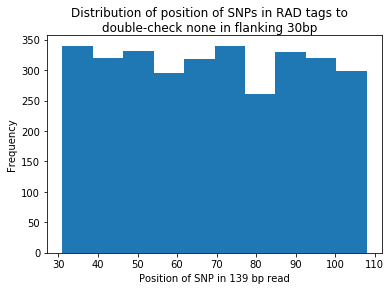

In [30]:
# double-check filtering for 30 bp cutoff is right, because played around w code and got new value
positions = []
for SNPname in kept_SNP_names:
    snp_list = SNPname.split("_")
    position = snp_list[1]
    positions.append(int(position))

# plot
plt.hist(positions)
plt.xlabel("Position of SNP in 139 bp read")
plt.ylabel("Frequency")
plt.suptitle("Distribution of position of SNPs in RAD tags to\ndouble-check none in flanking 30bp")
plt.show()

In [31]:
GP30_array = np.array(final_list)

In [32]:
# final array of just snps with 30 cut off
print GP30_array[0:9,0:9]

[['sample' 'FG001' 'FG002' 'FG003' 'FG004' 'FG005' 'FG006' 'FG007' 'FG009']
 ['13_72' '0101' '0101' '0101' '0101' '0101' '0101' '0101' '0104']
 ['20_52' '0303' '0303' '0101' '0303' '0303' '0303' '0303' '0303']
 ['20_59' '0204' '0202' '0202' '0202' '0202' '0202' '0202' '0202']
 ['31_69' '0102' '0101' '0102' '0101' '0101' '0101' '0101' '0101']
 ['63_87' '0404' '0204' '0204' '0204' '0404' '0404' '0404' '0204']
 ['63_107' '0204' '0404' '0404' '0404' '0404' '0404' '0404' '0404']
 ['80_84' '0303' '0303' '0000' '0303' '0000' '0304' '0303' '0303']
 ['86_38' '0204' '0202' '0202' '0202' '0202' '0202' '0204' '0202']]


In [33]:
# report MAF

all_maf_dict = {}

locus_list = []
for locusrow in GP30_array[1:,]: # iterate across individual genotypes within a locus
    ind_maf_dict = {} # initiate dictionary to store allele frequencies
    locus = locusrow[0]
    locus_list.append(locus)
    genlist = locusrow[1:]
    gencount = 0 # initiate counter for number of genotypes that aren't missing data
    for genotype in genlist:
        if genotype != "0000":
            gencount += 1
            allele_list = [genotype[0:2],genotype[2:4]] # assumes your genotypes are two digit format
            for allele in allele_list:
                if allele not in ind_maf_dict:
                    ind_maf_dict[allele] = 1
                if allele in ind_maf_dict:
                    oldcount = ind_maf_dict[allele]
                    newcount = oldcount + 1
                    ind_maf_dict[allele] = newcount
    all_maf_dict[locus] = []
    alleles = ind_maf_dict.keys()
    num_alleles = len(alleles)
    total_count = sum(ind_maf_dict.values())
    for allele in alleles:
        count = ind_maf_dict[allele]
        maf = float(count)/float(total_count)
        maf_list = all_maf_dict[locus]
        maf_list.append(maf)
        all_maf_dict[locus] = maf_list

print all_maf_dict.values()[0:9]

[[0.9296875, 0.0703125], [0.47619047619047616, 0.5238095238095238], [0.8615384615384616, 0.13846153846153847], [0.417910447761194, 0.582089552238806], [0.11538461538461539, 0.8846153846153846], [0.9444444444444444, 0.05555555555555555], [0.0625, 0.9375], [0.11363636363636363, 0.8863636363636364], [0.9285714285714286, 0.07142857142857142]]


In [34]:
# checking to see if all biallelic

count = 0
for item in all_maf_dict.values():
    length = len(item)
    if length > 2:
        count += 1
print count
if count == 0:
    print "All of your SNPs have no more than two alleles. Hooray for biallelic data."

# 0 means no SNPs had more than two alleles

0
All of your SNPs have no more than two alleles. Hooray for biallelic data.


You found 1055 SNPs with a MAF higher than .2

These SNPs occurred in 810 RAD tags.


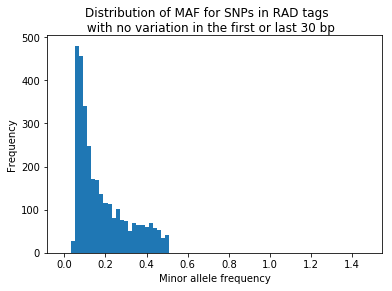

In [35]:
import matplotlib.pyplot as plt
import numpy as np

maf_list = []
RADtag_list = [] # for RAD tags with at least one SNP MAF greater than .2
count = 0

for SNP in kept_SNP_names:
    snplist = SNP.split("_")
    RADtag = snplist[0]
    afs = all_maf_dict[SNP]
    afs.sort()
    maf_list.append(afs[0])
    if afs[0] > .2:
        count += 1
        if RADtag not in RADtag_list:
            RADtag_list.append(RADtag)
        
print "You found " + str(count) + " SNPs with a MAF higher than .2"

print "\nThese SNPs occurred in " + str(len(RADtag_list)) + " RAD tags."
    
plt.hist(maf_list, np.arange(0,max(maf_list)+1,.02)-.01)
plt.suptitle("Distribution of MAF for SNPs in RAD tags \n with no variation in the first or last 30 bp")
plt.xlabel("Minor allele frequency")
plt.ylabel("Frequency")
plt.show()  

## Filtering for Fis

Fis is a measure of departure from Hardy Weinberg Equilibrium. We want to filter out those that deviate much from 0. I now realize that my across populations Fis plots are buggy, so going to rerun hierfstat appropriately and update those Fis plots elsewhere in my analyses and notebooks.

**20170420**
<br>Finished debugging. The new improved plots look like this:

![image](https://github.com/nclowell/RAD_Scallops/blob/master/CRAGIG_run1/Analyses/Fis/snp_fis_across_pops_20170420.png?raw=true)

![image](https://github.com/nclowell/RAD_Scallops/blob/master/CRAGIG_run1/Analyses/Fis/hap_fis_across_pops_20170420.png?raw=true)

So, to filter for Fis, I should get Fis values for the selected loci that are in RAD tags without variation in first or last 30 base pairs and plot their distribution.

In [36]:
cd /mnt/hgfs/SHARED_FOLDER/WorkingFolder

/mnt/hgfs/SHARED_FOLDER/WorkingFolder


In [37]:
# import Fis information for SNPs
snps_all_fis_file = open("fis_snps_postfilter_allpops_20170418.csv")
snps_all_fis_lines = snps_all_fis_file.readlines()
snps_all_fis_lines = snps_all_fis_lines[1:]
snps_all_fis_file.close()

In [38]:
snp_name_fis_list = []
for line in snps_all_fis_lines:
    linelist = line.strip().split(",")
    snp_name = linelist[0]
    fis = float(linelist[1])
    sublist = [snp_name, fis]
    snp_name_fis_list.append(sublist)

In [39]:
print snp_name_fis_list[0:4]

[['5_137', 0.5765], ['13_72', 0.1196], ['20_52', 0.5264], ['20_59', 0.5511]]


In [42]:
fis_30 = []

for SNP in kept_SNP_names:
    for sublist in snp_name_fis_list:
        if sublist[0] == SNP:
            fis_30.append(sublist[1])

In [48]:
fis_30[0:19]

[0.1196,
 0.5264,
 0.5511,
 -0.0957,
 0.1881,
 -0.0847,
 0.445,
 -0.0579,
 -0.0579,
 0.1702,
 -0.134,
 -0.0755,
 0.4698,
 -0.0556,
 -0.0909,
 -0.1589,
 0.1998,
 0.3077,
 0.3641]

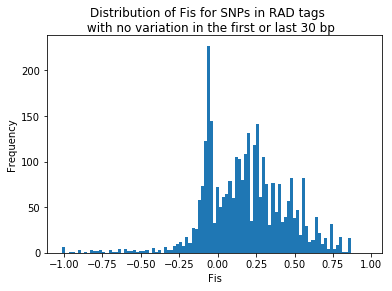

In [53]:
plt.hist(fis_30, np.arange(-1,max(fis_30),.02)-.01)
plt.suptitle("Distribution of Fis for SNPs in RAD tags \n with no variation in the first or last 30 bp")
plt.xlabel("Fis")
plt.ylabel("Frequency")
plt.show()  